# Quora 

# Problem Statement
#### 1. maping the same type of question.
#### 2. same type of question can be feede with the previous answer

# Objective
#### 1. cost of miss-classification can be very heigh
#### 2. problity of dublicate question so that we chooce any thresold.
#### 3. latency can be heigh [in sec]
#### 4. must be partially interpretabiblity 

# Data
## Data overview
#### 1. train dat have 6col -> id,qid1,qid2,question1,question2
##### > id - the id of a training set question pair
##### > qid1, qid2 - unique ids of each question (only available in train.csv)
##### > question1, question2 - the full text of each question
##### > is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

# Type of machine learing problem we are solving
#### its a binary classification problem, for pair of question we need to predict duplicate or not 

# Preformance Matric
#### log-loss 
#### confusion matric

# Spliting of Data
#### we will use random sapling(80:20 or 70:30) but in real world its time based spliting

# EDA on Quora Data

In [ ]:
!pip install distance

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import os
import re
import gc
from subprocess import check_output
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/machine learning/Quora/trains.zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.shape

(404290, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
x = df['is_duplicate'].value_counts()
print("% of not similar question : ",((len(df)-x[1])/len(df))*100,"and count is:",x[0] )
print("\n % of similar question: ",((len(df)-x[0])/len(df))*100," and the count is: ",x[1])

% of not similar question :  63.08021469737069 and count is: 255027

 % of similar question:  36.9197853026293  and the count is:  149263


# Number of unique question

In [ ]:
no_ques = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
no_rep_ques = sum(no_ques.value_counts()>1)
total_question = len(no_ques.value_counts())
print("number of repeting question",no_rep_ques)
print("number of unique question",(no_rep_ques)," in%",(((total_question-no_rep_ques)/total_question)*100))
print("max number of times questin repeted",max(no_ques.value_counts()))

number of repeting question 111780
number of unique question 111780  in% 79.22046054062494
max number of times questin repeted 157


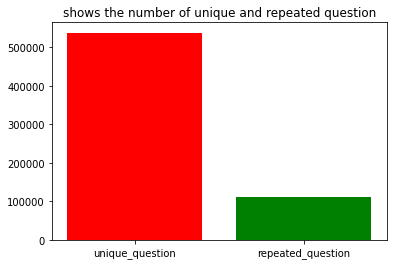

In [ ]:
# ploting the above data
x=['unique_question','repeated_question']
y=[total_question,no_rep_ques]
plt.bar(x,height=y,color=['r','g'])
plt.title("shows the number of unique and repeated question")
plt.show()

# Cheking of number of duplicate row

In [ ]:
paired_dup = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2','is_duplicate'])

In [ ]:
print("number of duplicate",df.shape[0]-len(paired_dup))

number of duplicate 0


# Ploting the number of occurence

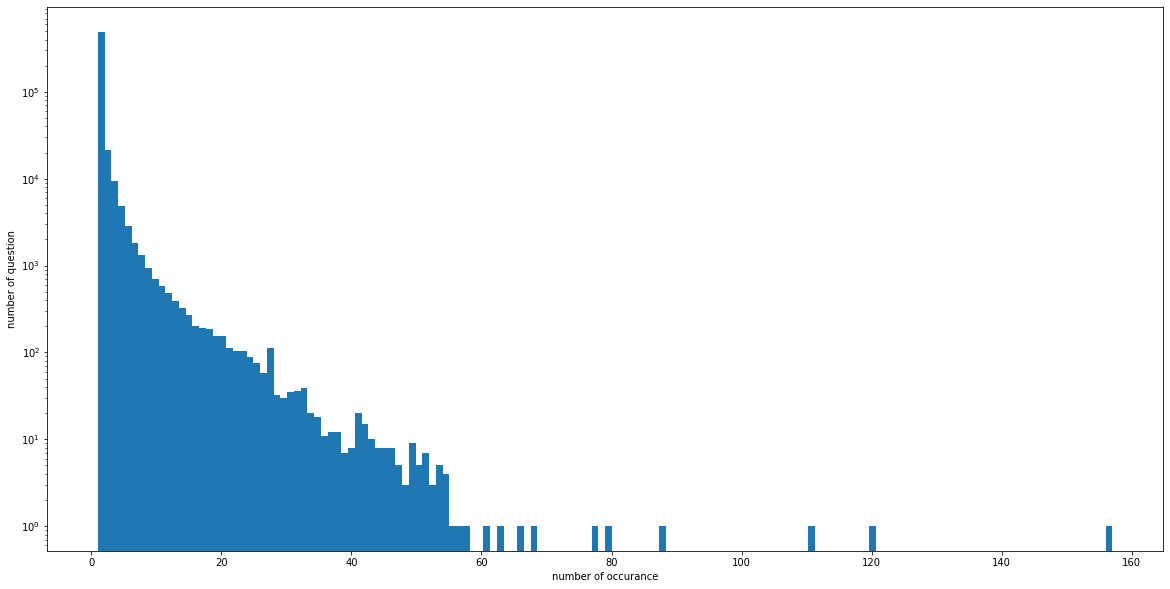

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(no_ques.value_counts(),bins=150)
plt.yscale("log")
plt.xlabel("number of occurance")
plt.ylabel("number of question")
plt.show()

# Checking for Null value

In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
### we will dropna
df.dropna(axis=0,inplace=True)
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

# Feature Engineering

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
data = df.copy()

In [ ]:
data['freq_qid1'] = data.groupby(['qid1'])['qid1'].transform('count')
data['freq_qid2'] = data.groupby(['qid2'])['qid2'].transform('count')
data['q1len'] = data['question1'].str.len()
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda x: len(str(x).split(' ')))
data['q2_n_words'] = data['question2'].apply(lambda x: len(str(x).split(' ')))

In [ ]:
def comman_word(w1):
  st1 = set(str(w1['question1']).lower().split(' '))
  st2 = set(str(w1['question2']).lower().split(' '))
  return len(st1.intersection(st2))
data['word_common'] = data.apply(comman_word,axis=1)

def total_word(w1):
  st1 = set(str(w1['question1']).lower().split(' '))
  st2 = set(str(w1['question2']).lower().split(' '))
  return len(st1)+len(st2)
data['word_total'] = data.apply(total_word,axis=1)

def word_share(w1):
  st1 = set(str(w1['question1']).lower().split(' '))
  st2 = set(str(w1['question2']).lower().split(' '))
  return len(st1.intersection(st2))/(len(st1)+len(st2))
data['word_share'] = data.apply(word_share,axis=1)

data['freq_q1+freq_q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-freq_q2'] = abs(data['freq_qid1']-data['freq_qid2'])

In [ ]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


# Anaalysis on Created Features

In [ ]:
print("minimum length of question1: ",min(data['q1_n_words']))
print("minimum length of question2",min(data['q1_n_words']))

print("number of question with minimum length [question1]",len(data[data['q1_n_words']==min(data['q1_n_words'])]))
print("number of question with minimum length [question2]",len(data[data['q2_n_words']==min(data['q2_n_words'])]))

minimum length of question1:  1
minimum length of question2 1
number of question with minimum length [question1] 66
number of question with minimum length [question2] 22


###### > So here we have 66 q1 with one word and 22 q2 with one word


#### > Feature:Word_shared

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



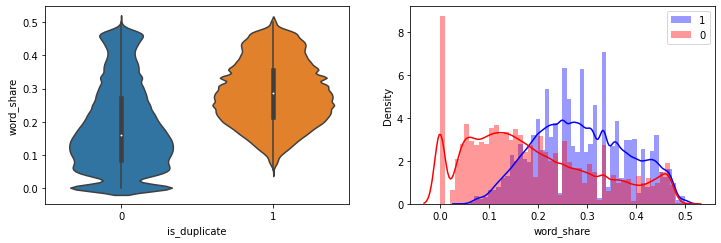

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.violinplot(x='is_duplicate',y='word_share',data=data[0:])

plt.subplot(222)
sns.distplot(data[data['is_duplicate']==1]['word_share'],label='1',color='b')
sns.distplot(data[data['is_duplicate']==0]['word_share'],label='0',color='r')
plt.legend()
plt.show()

here we have the overlap so we can't brake down into perfect two.

#### > word common

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



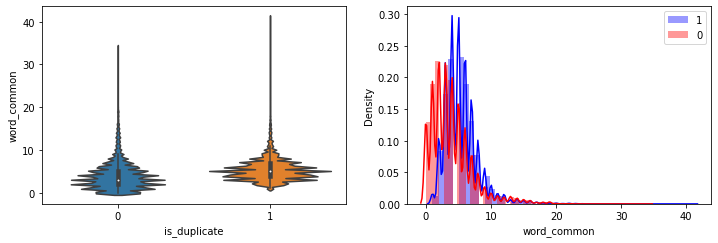

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.violinplot(x='is_duplicate',y='word_common',data=data[0:])

plt.subplot(222)
sns.distplot(data[data['is_duplicate']==1]['word_common'],label='1',color='b')
sns.distplot(data[data['is_duplicate']==0]['word_common'],label='0',color='r')
plt.legend()
plt.show()

> This is even worser than the previous one plots are completely overlaping each other

# Text preprocessing 
##### - removing html tags
##### - Removing the punctuation
##### - Stemming
##### - Stop Words
##### - Expanding contractions



In [ ]:
!pip install fuzzywuzzy

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings

import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/machine learning/Quora/trains.zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.dropna(axis=0,inplace=True)
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
save_div = 0.0001
stopword = stopwords.words('english')

def process(x):
  x = str(x).lower()

  x =  x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000",r"\1k",x)
  x = re.sub(r"<.*?>",' ',x)# this can also be done through BeautifulSoup lib
  porter = PorterStemmer()
  x = re.sub(r'\W',' ',x)
  x = porter.stem(x)

  return x

#Advanced Feature Extraction (NLP and Fuzzy Features) 
 all is advance feature are been known form the kaggle discussion and kaggle winnner solution

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
     
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2

- __fuzz_ratio__ :  similartiy between two string on complete string

- __fuzz_partial_ratio__ :  even there is one word and it completely maches with a word in 2nd string it will return a score of 100 where in fuzz.ration gives small value(~55)

- __token_sort_ratio__ : it gives us a good score even if order are not same 
note other two take the order of presence also 

- __token_set_ratio__ : it give us a good score if the length of the two string are not same and 2 sting have length>2

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
#*** function to get basic feature***#
def get_tokens(q1,q2):
  token = [0.0]*10

  q1_token = q1.split(' ')
  q2_token = q2.split(' ')

  q1_words = set([words for words in q1_token if words not in stopword])
  q2_words = set([words for words in q2_token if words not in stopword])
  
  q1_stop = set([words for words in q1_token if words in stopword])
  q2_stop = set([words for words in q2_token if words in stopword])

  common_word_count = len(q1_words.intersection(q2_words))
  common_stop_count = len(q1_stop.intersection(q2_stop))
  common_token_count = len(set(q1_token).intersection(q2_token))

  token[0] = common_word_count/(min(len(q1_words),len(q2_words))+save_div)
  token[1] = common_word_count/(max(len(q1_words),len(q2_words))+save_div)
  token[2] = common_stop_count/(min(len(q1_stop),len(q2_stop))+save_div)
  token[3] = common_stop_count/(max(len(q1_stop),len(q2_stop))+save_div)
  token[4] = common_token_count/(min(len(q1_token),len(q2_token))+save_div)
  token[5] = common_token_count/(max(len(q1_token),len(q2_token))+save_div)

  token[6] = int(q1_token[-1]==q2_token[-1])
  token[7] = int(q1_token[0]==q2_token[0])
  token[8] = abs(len(q1_token)-len(q2_token))
  token[9] = (len(q1_token) + len(q2_token))/2

  return token

#***extra feature to get substring***# 
def get_longest_substr_ratio(a,b):
  strs = list(distance.lcsubstrings(a, b))
  if len(strs)==0:
    return 0

  return len(strs[0]) / (min(len(a), len(b)) + 1)

#***features adding to the dataframe***#
#*** fuzz feature***#
#***master function***#
def extra_feature(df):
  df['question1'] = df['question1'].apply(process)
  df['question2'] = df['question2'].apply(process)

  token_feature = df.apply(lambda x :get_tokens(x['question1'],x['question2']),axis=1)

  print('extra feature...')

  df['cwc_min'] = list(map(lambda x: x[0],token_feature))
  df['cwc_max'] = list(map(lambda x: x[1],token_feature))
  df['csc_min'] = list(map(lambda x: x[2],token_feature))
  df['csc_max'] = list(map(lambda x: x[3],token_feature))
  df['ctc_min'] = list(map(lambda x: x[4],token_feature))
  df['ctc_max'] = list(map(lambda x: x[5],token_feature))
  df['last_word_eq'] = list(map(lambda x: x[6], token_feature))
  df['first_word_eq'] = list(map(lambda x: x[7], token_feature))
  df['abs_len_diff'] = list(map(lambda x: x[8], token_feature))
  df['mean_len'] = list(map(lambda x: x[9], token_feature))

  print('fuzz feature...')
  df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'],x['question2']),axis=1)
  df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'],x['question2']),axis=1)
  df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']),axis=1)
  df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']),axis=1)
  df['get_longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'],x['question2']),axis=1)

  return df

df = extra_feature(df)

In [ ]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999983,0.857131,0.999983,0.999983,0.92307,0.799995,1,1,2,14.0,93,100,100,93


In [ ]:
df.to_csv("/content/drive/MyDrive/machine learning/Quora/fuzz_df.csv")

# Analysis of extra feature
ploting the word colud for the is_duplicate=0and1


In [ ]:
df_duplicate = df[df['is_duplicate']==1]
df_notduplicate = df[df['is_duplicate']==0]

p = np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n = np.dstack([df_notduplicate['question1'],df_notduplicate['question2']]).flatten()

print("number of data points in duplicate=1: ",len(p))
print("number of data points in duplicate=0: ",len(n)) 

np.savetxt("/content/drive/MyDrive/machine learning/Quora/train_p.txt",p,delimiter=' ',fmt="%s")
np.savetxt("/content/drive/MyDrive/machine learning/Quora/train_n.txt",n,delimiter=' ',fmt="%s")

number of data points in duplicate=1:  298526
number of data points in duplicate=0:  510048


In [ ]:
textp_w = open(path.join('/content/drive/MyDrive/machine learning/Quora/train_p.txt')).read()
textn_w = open(path.join('/content/drive/MyDrive/machine learning/Quora/train_n.txt')).read()

stw = set(STOPWORDS)
stw.add("said")
stw.add("br")
stw.add(" ")
stw.remove("not")
stw.remove("no")
stw.remove("like")
print("number of words in is_duplicate=1: ",len(textp_w))
print("number of words in is_duplicate=0: ",len(textn_w))

number of words in is_duplicate=1:  16109894
number of words in is_duplicate=0:  33192398


> ploting the word colud for the duplicate

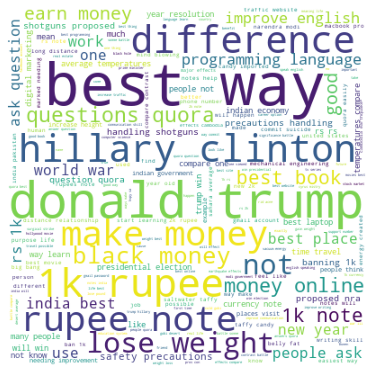

In [ ]:
wordcloud = WordCloud(width=400,height=400,stopwords=stw,background_color="white").generate(textp_w)
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

> now ploting for the non duplicate words

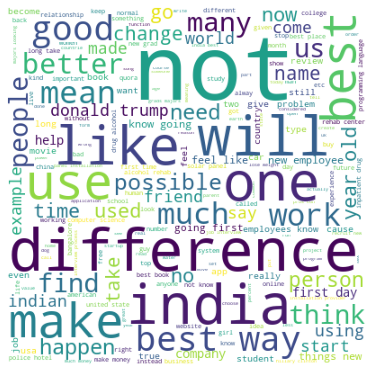

In [ ]:
wordcloud = WordCloud(width=400,height=400,stopwords=stw,background_color="white").generate(textn_w)
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

_>_ some word occur more in class 1 than in class 0 and vise warsa

#### pair plot the feature ['cwc_min','csc_min','ctc_min','token_sort_ratio']

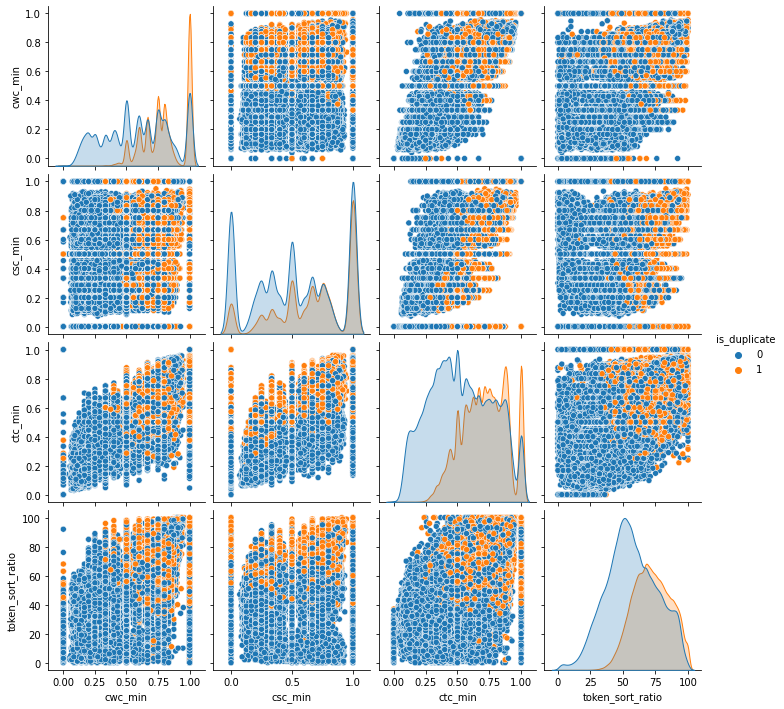

In [ ]:
sns.pairplot(df[['cwc_min','csc_min','ctc_min','token_sort_ratio','is_duplicate']],hue='is_duplicate',)

token_sort_ratio feature


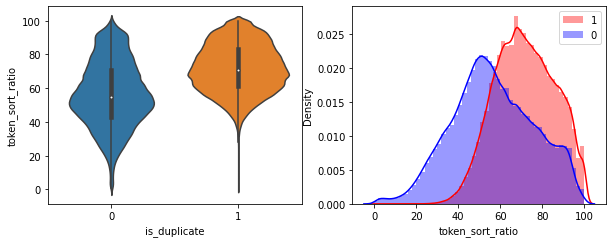

In [ ]:
print("token_sort_ratio feature")
plt.figure(figsize=(10,8))
plt.subplot(221)
sns.violinplot(x='is_duplicate',y='token_sort_ratio',data=df[0:])
plt.subplot(222)
sns.distplot(df[df['is_duplicate']==1]['token_sort_ratio'],color='r',label=1)
sns.distplot(df[df['is_duplicate']==0]['token_sort_ratio'],color='b',label=0)
plt.legend()
plt.show()

# visualization

In [ ]:
## appling the tsne tech for dimension reduction
df_subsample = df[:5000]
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(df_subsample[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','fuzz_ratio','fuzz_partial_ratio','token_set_ratio','token_sort_ratio']])
y = df_subsample['is_duplicate'].values


In [ ]:
tsne1 = TSNE(
    n_components=2,
    init = 'random',
    angle=0.5,
    method='barnes_hut',
    random_state=101,
    n_iter=1000,
    verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.107273
[t-SNE] Computed conditional probabilities in 0.333s
[t-SNE] Iteration 50: error = 82.2666626, gradient norm = 0.0384884 (50 iterations in 2.488s)
[t-SNE] Iteration 100: error = 72.5907288, gradient norm = 0.0075853 (50 iterations in 1.860s)
[t-SNE] Iteration 150: error = 71.4195099, gradient norm = 0.0040230 (50 iterations in 1.986s)
[t-SNE] Iteration 200: error = 70.9344330, gradient norm = 0.0040153 (50 iterations in 2.025s)
[t-SNE] Iteration 250: error = 70.6542664, gradient norm = 0.0023050

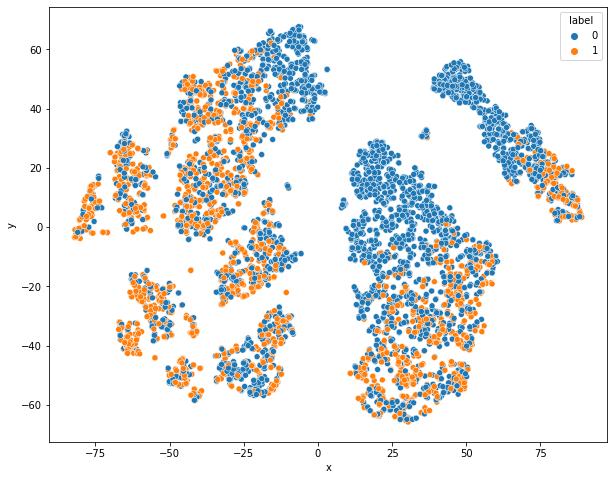

In [ ]:
df1 = pd.DataFrame({'x':tsne1[:,0],'y':tsne1[:,1],'label':y})
plt.figure(figsize=(10,8))
sns.scatterplot(x='x',y='y',data=df1,hue='label')
plt.show()

 # Featurizing text data with tfidf weighted word-vectors 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/machine learning/Quora/trains.zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.dropna(inplace=True,axis=0)

In [ ]:
type(df['question1'])

pandas.core.series.Series

In [ ]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
questions = list(df['question1']+df['question2'])


In [ ]:
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
!python -m spacy download en_core_web_md

using glove it works same as weighted tfidfw2vec.
 
glove can easky be implemented by spacy library

In [ ]:
nlp = spacy.load("en_core_web_sm")
vecs1 = []
for que in tqdm(df['question1']):
  doc1 = nlp(que)

  mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
  for word1 in doc1:
    try:
        idf = word2tfidf[str(word1)]
        vec1 = word1.vector
    
    except:
        idf = 0
    mean_vec1 += vec1 * idf
  mean_vec1 = mean_vec1.mean(axis=0)
  vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404287/404287 [1:03:11<00:00, 106.62it/s]


In [ ]:
vecs2 = []
for que2 in tqdm(df['question2']):
  doc2 = nlp(que2)
  mean_vec = np.zeros(len(doc2),len(doc2[0].vector))
  for word2 in doc2:
    vec2 = word2.vector
    try:
      idf = word2tfidf[str(word2)]
    except:
      idf=0
    mean_vec+=vec2*idf
  mean_vec = mean_vec.mean(axis=0)
  vecs2.append(mean_vec)
df['q2_feats_m'] = list(vecs2)

# making one csv file of nlp_feature+fuzz_feature+basic_feat

# machine learing modeling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [12]:
data = pd.read_csv('/content/drive/MyDrive/machine learning/Quora/final_features.csv')
data.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,38.575120,...,-14.608611,-14.153514,-29.568828,29.144799,41.087017,-6.711498,-8.812467,7.906522,-27.432420,10.599943,16.952886,-15.785523,-18.361750,-23.125756,-7.145598,-15.993189,-0.493609,3.726502,25.448065,16.128444,-27.806874,-2.436932,5.134369,-8.074996,24.421846,8.739254,-17.285154,13.440285,-13.209145,1.079919,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,52.444493,...,-8.954575,-15.803814,-5.150883,17.270690,14.479286,-8.041332,-37.765046,8.256755,-37.232596,0.989206,11.408972,-3.191425,-12.339837,-24.161270,-10.353968,-28.326909,-12.874845,6.732092,8.607652,0.745432,-25.891975,-9.892551,-6.407806,-1.322369,15.972339,17.672533,-9.950780,0.094202,-13.221513,-14.747519,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [13]:
data = data.head(100001)

In [14]:
data.drop(data.index[0], inplace=True)
y = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
data.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.2,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.01351,-39.14073,-82.692352,45.161489,-9.556289,-79.721632,25.81864,-7.883405,-124.308125,...,-1.66362,-0.402938,-14.087219,38.538202,9.727834,13.91781,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.29645,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.56808,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.70307,0.40804


In [15]:
cols = list(data.columns)
for i in cols:
  data[i] = data[i].apply(pd.to_numeric)
  print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [16]:
y = list(map(int,y))

#### spliting  the data

In [17]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=.2,random_state=42,stratify=y)

function to plot cunfusion matrix,precision and recall

In [27]:
def plots(y_acc,y_pred):
  c = confusion_matrix(y_acc,y_pred)
  ## note in matrix the axis=0 means col and axis=1 row
  pre = ((c.T)/(c.sum(axis=0))).T
  rec = (c)/c.sum(axis=1)

  ## ploting the matrix
  labels = [0,1]
  plt.figure(figsize=(20,4))
  ## confusion matrix ploting
  plt.subplot(131)
  cmap=sns.light_palette("orange")
  sns.heatmap(c,cmap=cmap,annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("predected")
  plt.ylabel("orignal")
  plt.title("confusion matric")

  ## ploting precision matric
  plt.subplot(132)
  cmap=sns.light_palette("orange")
  sns.heatmap(pre,cmap=cmap,annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("predected")
  plt.ylabel("orignal")
  plt.title("precision matric")

  ## ploting recall matric
  plt.subplot(133)
  cmap=sns.light_palette("orange")
  sns.heatmap(rec,cmap=cmap,annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel("predected")
  plt.ylabel("orignal")
  plt.title("recall matric")
  plt.show()



# Logistic Regression with hyperparameter tuning

In [19]:
alpha = [10**i for i in range(-5,2)]

for i in alpha:
  cls = SGDClassifier(loss='log',alpha=i,random_state=42,n_jobs=-1)
  cls.fit(X_train,y_train)
  clab = CalibratedClassifierCV(cls,method='sigmoid')
  clab.fit(X_train,y_train)
  y_pred = clab.predict_proba(X_test)
  print("for alpha=",i,"log_loss=",log_loss(y_test,y_pred))


for alpha= 1e-05 log_loss= 0.4747688822001394
for alpha= 0.0001 log_loss= 0.4536121821121058
for alpha= 0.001 log_loss= 0.44797288934929064
for alpha= 0.01 log_loss= 0.442078868015002
for alpha= 0.1 log_loss= 0.4459867219620072
for alpha= 1 log_loss= 0.48129159406400357
for alpha= 10 log_loss= 0.5244007104896398


__>__ here we got at alpha = 0.01 log_loss is minimal

__>__ we will train our final Lr on alpha =0.01

__>__ Confusion matric

In [ ]:
cls = SGDClassifier(loss='log',alpha=0.01,random_state=42,n_jobs=-1)
cls.fit(X_train,y_train)
clab = CalibratedClassifierCV(cls,method='sigmoid')
clab.fit(X_train,y_train)
y_pred_train = clab.predict_proba(X_train)
print("log_loss on train data:",log_loss(y_train,y_pred_train))
y_pred_test = clab.predict_proba(X_test)
print("\n log_loss on test data:",log_loss(y_test,y_pred_test))

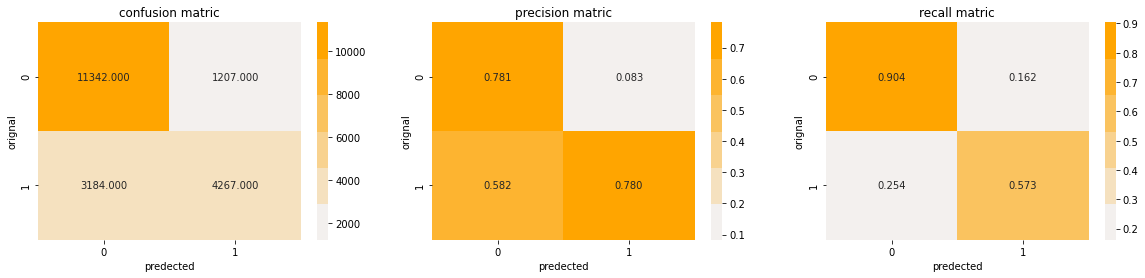

In [28]:
y_pred = np.argmax(y_pred_test,axis=1)
plots(y_test,y_pred)

# linear svm with hyperparameter tuning

In [ ]:
alpha = [10**i for i in range(-5,2)]

for i in alpha:
  cls = SGDClassifier(alpha=i,penalty='l1', loss='hinge',random_state=42,n_jobs=-1)
  cls.fit(X_train,y_train)
  clab = CalibratedClassifierCV(cls,method='sigmoid')
  clab.fit(X_train,y_train)
  y_pred = clab.predict_proba(X_test)
  print("for alpha=",i,"log_loss=",log_loss(y_test,y_pred))
